# DeMarkify (baseline)

**TO DO**

*Top Priority*
- Figure out infrence image size scaling (see below section)

*Sould get done at some point*
- Save pre-gan cylce gen/crit models seperate from normal ones
- More markify functions for better generalization
- Figure out what "fn_factor" and "fn" means
- Try using a bigger resnet for better feature detection
- Play with image size/bs with single gpu training
- Look at training options on GCP
- Web App stuff
- Get markify functions to scale with image size
- Try splitting up higher-res images into smaller images and peice them back together for inference
- create "benchmark" folders of test images being passed through different models/checkpoints 
- Look at critic "most confused" images (if possible) to find and delete "bad" training images

*Would be nice to have*
- Refactor utility functions for cleanliness
- Look into Tensorboard callbacks
- "Scriptify" notebook for training everything in 1 command




In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
from fastai.vision import *
from fastai.vision.gan import *
from fastai.layers import *
import dill as pickle

from PIL import Image, ImageDraw, ImageFont, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import string, time

from save import *
from util import *
from markify import *

In [ ]:
torch.cuda.set_device(0)
print(f"Using GPU {torch.cuda.current_device()}")

## Data

#### ImageNet ILSVRC2011 Trianing Set

Roughly 1.2 million images from the training set of an ImageNet competition (http://www.image-net.org/challenges/LSVRC/2011/registered-downloads)

In [ ]:
# Make subset for testing
image_subset(100, CLEAN, CLEAN_SUB)

In [ ]:
open_image(CLEAN_SUB.ls()[0])

In [ ]:
markify(CLEAN_SUB, MARKED_SUB)

In [ ]:
len(CLEAN_SUB.ls()), len(MARKED_SUB.ls())

In [ ]:
open_image(MARKED_SUB.ls()[0])

### Markify Images

In [ ]:
# %%time
# markify(CLEAN, MARKED)

In [ ]:
len(os.listdir(MARKED)), len(os.listdir(CLEAN))

In [ ]:
open_image(MARKED_SUB.ls()[5])

In [ ]:
open_image(CLEAN.ls()[4])

## Modeling

### Pretrain Generator

#### 64px

In [ ]:
gc.collect()

In [ ]:
bs = 88
sz = 64
keep_pct = 1.0

In [ ]:
data_gen = get_data(bs, sz, keep_pct, CLEAN)

In [ ]:
data_gen.show_batch(10)

In [ ]:
wd = 1e-3
y_range = (-3.,3.)
loss_gen = MSELossFlat()
# loss_gen = FeatureLoss()

In [ ]:
%%time
learn_gen = create_gen_learner(path=PATH)

In [ ]:
learn_gen.fit_one_cycle(1, pct_start=0.8, max_lr=slice(1e-3))

In [ ]:
learn_gen.save(pre_gen_name)

In [ ]:
learn_gen.unfreeze()

In [ ]:
learn_gen.fit_one_cycle(1, pct_start=pct_start, max_lr=slice(3e-7, 3e-4))

In [ ]:
learn_gen.save(pre_gen_name)

#### 128px

In [ ]:
bs = 22
sz = 128
keep_pct = 1.0

In [ ]:
learn_gen.data = get_data(bs, sz, keep_pct, CLEAN)

In [ ]:
learn_gen.unfreeze()

In [ ]:
learn_gen.fit_one_cycle(1, pct_start=pct_start, max_lr=slice(1e-7,1e-4))

In [ ]:
learn_gen.save(pre_gen_name)

#### 192px

In [ ]:
bs = 11
sz = 192
keep_pct = 0.50

In [ ]:
learn_gen.data = get_data(bs, sz, keep_pct, CLEAN)

In [ ]:
learn_gen.unfreeze()

In [ ]:
learn_gen.fit_one_cycle(1, pct_start=pct_start, max_lr=slice(5e-8,5e-5))

In [ ]:
learn_gen.save(pre_gen_name)

### GAN Cycle

Make sure `old_checkpoint_num` is set to 0 when training a new set of models.

In [ ]:
old_checkpoint_num = 0
checkpoint_num = old_checkpoint_num + 1
gen_old_checkpoint_name = f"{gen_name}_{str(old_checkpoint_num)}"
gen_new_checkpoint_name = f"{gen_name}_{str(checkpoint_num)}"
crit_old_checkpoint_name = f"{crit_name}_{str(old_checkpoint_num)}"
crit_new_checkpoint_name = f"{crit_name}_{str(checkpoint_num)}"

#### Save Generated Images

In [ ]:
bs = 8
sz = 192

In [ ]:
gen_old_checkpoint_name

In [ ]:
learn_gen = create_gen_learner(path=PATH).load(gen_old_checkpoint_name)

In [ ]:
import pdb

In [ ]:
def save_preds(dl):
#     pdb.set_trace()
    i=0
    names = dl.dataset.items
    
    for b in dl:
        preds = learn_gen.pred_batch(batch=b, reconstruct=True)
        for o in preds:
            o.save(IMG_GEN/names[i].name)
            i += 1
    
def save_gen_images():
#     pdb.set_trace()
    if IMG_GEN.exists(): shutil.rmtree(IMG_GEN)
    IMG_GEN.mkdir(exist_ok=True)
    data_gen = get_data(bs,sz, 0.085, CLEAN)
    save_preds(data_gen.fix_dl)
    PIL.Image.open(IMG_GEN.ls()[0])

In [ ]:
%%time
save_gen_images()

#### Pretrain Critic

In [ ]:
IMG_GEN

In [ ]:
# c_img = open_image("data/marked/ILSVRC2011_val_00046504.png")
# c_img

In [ ]:
IMG_GEN.ls()[9]

In [ ]:
img = open_image(IMG_GEN.ls()[9])
img

In [ ]:
img.size

In [ ]:
c_img = open_image(MARKED.ls()[9])
c_img

In [ ]:
gc.collect()

In [ ]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [ ]:
# loss_critic = AdaptiveLoss(nn.BCEWithLogitsLoss())

In [ ]:
if old_checkpoint_num == 0:
    bs = 64
    sz = 128
    learn_gen = None
    gc.collect()
    data_crit = get_crit_data(["image_gen", "clean"], bs, sz, PATH)
    data_crit.show_batch(rows=3, ds_type=DatasetType.Train, imgsize=3)
    loss_critic = AdaptiveLoss(nn.BCEWithLogitsLoss())
    learn_critic = create_critic_learner(data_crit, accuracy_thresh_expand, path=PATH)
    learn_critic.fit_one_cycle(6, 1e-3)
    learn_critic.save(crit_old_checkpoint_name)

In [ ]:
bs = 16
size = 192

In [ ]:
data_crit = get_crit_data(["image_gen", "clean"], bs, sz, PATH)

In [ ]:
data_crit.show_batch(rows=3, ds_type=DatasetType.Train, imgsize=3)

In [ ]:
learn_critic = create_critic_learner(data_crit, accuracy_thresh_expand, PATH).load(crit_old_checkpoint_name)

In [ ]:
learn_critic.fit_one_cycle(4, 1e-4)

In [ ]:
learn_critic.save(crit_new_checkpoint_name)

#### GAN

In [ ]:
learn_crit=None
learn_gen=None
gc.collect()

In [ ]:
bs = 9
sz = 192
lr = 1e-5

In [ ]:
data_crit = get_crit_data(['marked', 'clean'], bs, size, PATH)

In [ ]:
learn_crit = create_critic_learner(data_crit, metrics=None, path=PATH).load(crit_new_checkpoint_name)

In [ ]:
learn_gen = create_gen_learner(path=PATH).load(gen_old_checkpoint_name)

In [ ]:
switcher = partial(AdaptiveGANSwitcher, critic_thresh=0.65)
learn = GANLearner.from_learners(learn_gen, learn_crit, weights_gen=(1.,50.), show_img=False, switcher=switcher,
                                 opt_func=partial(optim.Adam, betas=(0.,0.99)), wd=wd, path=PATH)
learn.callback_fns.append(partial(GANDiscriminativeLR, mult_lr=5.))
learn.callback_fns.append(partial(GANSaveCallback, learn_gen=learn_gen, filename=gen_new_checkpoint_name, save_iters=1))

In [ ]:
keep_pct = 0.03
learn.data = get_data(bs, sz, keep_pct, CLEAN)

In [ ]:
learn_gen.freeze_to(-1)

In [ ]:
learn.fit(1, lr)

In [ ]:
learn.show_results(rows=12)

Export Model

In [ ]:
learn_gen = create_gen_learner(path=PATH).load(gen_new_checkpoint_name)
# learn_gen = create_gen_learner(path=PATH).load("small_gen_1")

In [ ]:
learn_gen.export()

## Playground

### Testing Inference Learner

**10/19/2019**
- *Fastai* Needs to be version 1.0.55 and *Pytorch* version 1.1.0 (See [this thread](https://forums.fast.ai/t/fastai-pytorch-import-error/52201/2?u=waydegg) and [this thread](https://forums.fast.ai/t/pixelshuffle-icnr-object-has-no-attribute-do-blur-on-binary-segmentation-prediction/53950/2?u=waydegg)) for training and exporting to torchscript

In [1]:
import fastai
from fastai.vision import *
from inference import markify_learner
from pathlib import Path
from config import *
import matplotlib.pyplot as plt
import torch
from torchvision import models, transforms
import torchvision.transforms.functional as F

In [2]:
fastai.__version__, torch.__version__

('1.0.59', '1.3.0')

In [3]:
PATH = Path("data")
TEST = Path(PATH/'test_pics')
TEST.ls()

[PosixPath('data/test_pics/wayde.jpg'),
 PosixPath('data/test_pics/dims.jpg'),
 PosixPath('data/test_pics/test1.jpg'),
 PosixPath('data/test_pics/pred_img_gen.png'),
 PosixPath('data/test_pics/old-age-tourism-travel-people-450w-1009880623.jpg'),
 PosixPath('data/test_pics/pred_img.png'),
 PosixPath('data/test_pics/test6.jpg'),
 PosixPath('data/test_pics/waydegg@blacklab.ddns.net'),
 PosixPath('data/test_pics/angery_rudy.jpg'),
 PosixPath('data/test_pics/swirl.png'),
 PosixPath('data/test_pics/pred_img_0.png'),
 PosixPath('data/test_pics/test5.jpg'),
 PosixPath('data/test_pics/test4.jpg'),
 PosixPath('data/test_pics/0172.jpg'),
 PosixPath('data/test_pics/test3.jpg'),
 PosixPath('data/test_pics/test2.jpg'),
 PosixPath('data/test_pics/0172 (1).jpg'),
 PosixPath('data/test_pics/0325.jpg'),
 PosixPath('data/test_pics/gary.jpg')]

Load Torch Model

In [4]:
model_path = "data/models/larger_input.pkl"
model = torch.jit.load(model_path, map_location=torch.device('cpu')).eval()

In [5]:
# torch image preprocessing
preprocess = transforms.Compose([
    transforms.Resize((192,192)),
    transforms.ToTensor()
])

In [6]:
img_url = "https://thumbs.dreamstime.com/z/couple-business-people-giving-thumbs-up-10536066.jpg"
img_request = requests.get(img_url, stream=True)
img = PIL.Image.open(io.BytesIO(img_request.content))
img_tensor = preprocess(img)
img_tensor = img_tensor.unsqueeze(0)
img_tensor.shape

torch.Size([1, 3, 192, 192])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


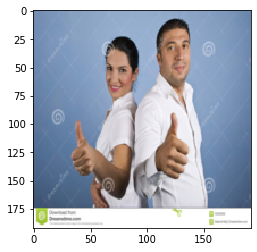

In [7]:
output_img = model(img_tensor)
output_img = np.squeeze(output_img)
# output_img = output_img.squeeze()
plt.imshow(output_img.permute(1,2,0))

Load Fastai Model

In [8]:
learner = markify_learner("data/models", "larger_input.pkl")

RuntimeError: data/models/larger_input.pkl is a zip archive (did you mean to use torch.jit.load()?)

In [ ]:
# torch image preprocessing
preprocess = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor()
])

In [ ]:
img = open_image(TEST/"test3.jpg")
display(img.size, img)

In [ ]:
learner.generate_image(img)

### Exporting Model to AWS Lambda

To compile Unet models, you have to comment out the line in pytorch that raises a value error if your model has hooks. See [this thread](https://stackoverflow.com/a/56242858/3654891) for more details.

In [9]:
import tarfile
from fastai.vision import *
import torch

In [10]:
fastai.__version__, torch.__version__

('1.0.59', '1.3.0')

Since there are package conficts with the **demarkify_dev** conda environment, use **demarkify_sam** to upload the model to s3 (see export.py). To upload to s3, just call ``export.py`` and it will upload everything for you to s3.

In [11]:
!python export.py

Traceback (most recent call last):
  File "export.py", line 27, in <module>
    model_to_upload = markify_learner("/mnt/nvme/backup/models", "demarkify_original.pkl").model
  File "/home/waydegg/development/projects/demarkify/project_dev/inference.py", line 7, in __init__
    self.model = load_learner(model_path, fn)
  File "/home/waydegg/anaconda3/envs/demarkify_dev/lib/python3.7/site-packages/fastai/basic_train.py", line 616, in load_learner
    state = torch.load(source, map_location='cpu') if defaults.device == torch.device('cpu') else torch.load(source)
  File "/home/waydegg/anaconda3/envs/demarkify_dev/lib/python3.7/site-packages/torch/serialization.py", line 422, in load
    f = f.open('rb')
  File "/home/waydegg/anaconda3/envs/demarkify_dev/lib/python3.7/pathlib.py", line 1193, in open
    opener=self._opener)
  File "/home/waydegg/anaconda3/envs/demarkify_dev/lib/python3.7/pathlib.py", line 1046, in _opener
    return self._accessor.open(self, flags, mode)
FileNotFoundError: [

### SAM Inference Testing

In [ ]:
try:
    
    import unzip_requirements
except ImportError:
    pass

import os
import io
import json
import tarfile
import glob
import time
import logging

# import boto3
import pdb
import requests
import PIL

import torch
import torch.nn.functional as F
from torchvision import models, transforms
from torchvision.utils import save_image

In [ ]:
# # load s3 client
# s3 = boto3.client('s3')

# load logger
logger = logging.getLogger()
logger.setLevel(logging.INFO)

In [ ]:
# get bucket name from ENV variable
# MODEL_BUCKET = os.environ.get('MODEL_BUCKET')
MODEL_BUCKET = "demarkify-models"
logger.info(f"Model Bucket is {MODEL_BUCKET}")

# get bucket prefix from ENV variable
# MODEL_KEY = os.environ.get('MODEL_KEY')
MODEL_KEY = "demarkify/test_model_save.tar.gz"
logger.info(f"Model Prefix is {MODEL_KEY}")

In [ ]:
MODEL_BUCKET, MODEL_KEY

In [ ]:
# torch image preprocessing
preprocess = transforms.Compose([
    transforms.Resize((512,512)),
    transforms.ToTensor()
])

In [ ]:
model = load_model(use_s3=False, saved_model="data/models/larger_input.tar.gz")

In [ ]:
img_url = "https://thumbs.dreamstime.com/z/couple-business-people-giving-thumbs-up-10536066.jpg"
img_request = requests.get(img_url, stream=True)
img = PIL.Image.open(io.BytesIO(img_request.content))
img_tensor = preprocess(img)
img_tensor = img_tensor.unsqueeze(0)
save_image(img_tensor[0], 'data/test_pics/pred_img.png')
open_image('data/test_pics/pred_img.png')

In [ ]:
img_tensor.shape

In [ ]:
pred_img = predict(img_tensor, model)[0]

In [ ]:
model(img_tensor)

In [ ]:
?save_image

In [ ]:
save_image(pred_img, 'data/test_pics/pred_img_gen.png')

In [ ]:
open_image('data/test_pics/pred_img_gen.png')

Use Imgbb Api and requests-html to upload images

In [27]:
from requests_html import HTMLSession
import base64

In [16]:
session = HTMLSession()

In [18]:
!ls data/test_pics

'0172 (1).jpg'					     swirl.png
 0172.jpg					     test1.jpg
 0325.jpg					     test2.jpg
 angery_rudy.jpg				     test3.jpg
 dims.jpg					     test4.jpg
 gary.jpg					     test5.jpg
 old-age-tourism-travel-people-450w-1009880623.jpg   test6.jpg
 pred_img_0.png					     waydegg@blacklab.ddns.net
 pred_img_gen.png				     wayde.jpg
 pred_img.png


In [28]:
image_path = "data/test_pics/test5.jpg"

with open(image_path, "rb") as image_file:
    encoded_string = base64.b64encode(image_file.read())

In [30]:
imgbb_key = "de0c1bcd22f365af6742a8f770684b70"

upload_form = {
    "image": encoded_string
}

In [36]:
r = session.post(f"https://api.imgbb.com/1/upload?key={imgbb_key}", data=upload_form)

In [43]:
r.json()

{'data': {'id': 'V3Xn0ZN',
  'url_viewer': 'https://ibb.co/V3Xn0ZN',
  'url': 'https://i.ibb.co/yVLvm1R/b26d35d6ffe4.jpg',
  'display_url': 'https://i.ibb.co/yVLvm1R/b26d35d6ffe4.jpg',
  'title': 'b26d35d6ffe4',
  'time': '1572143631',
  'image': {'filename': 'b26d35d6ffe4.jpg',
   'name': 'b26d35d6ffe4',
   'mime': 'image/jpeg',
   'extension': 'jpg',
   'url': 'https://i.ibb.co/yVLvm1R/b26d35d6ffe4.jpg',
   'size': 20399},
  'thumb': {'filename': 'b26d35d6ffe4.jpg',
   'name': 'b26d35d6ffe4',
   'mime': 'image/jpeg',
   'extension': 'jpg',
   'url': 'https://i.ibb.co/V3Xn0ZN/b26d35d6ffe4.jpg',
   'size': '11855'},
  'delete_url': 'https://ibb.co/V3Xn0ZN/e0a2bdfd8f57a93abca46584fdf8160a'},
 'success': True,
 'status': 200}